### Pytorch Ecosystem for Training Neural Networks

## MultiLayer Perceptron for FashionMNIST Dataset Using Pytorch Ignite
* Reference: https://pytorch-ignite.ai

In [2]:
# Install dependencies
!pip install torch torchvision
!pip install tqdm matplotlib numpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.4 MB/s eta 0:00:00


In [4]:
#import Libarires
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from ignite.engine import Engine, Events
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
import matplotlib.pyplot as plt

<ipython-input-4-fe31a9721d90>:9: DeprecationWarning: /usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py has been moved to /ignite/handlers/tqdm_logger.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  from ignite.contrib.handlers.tqdm_logger import ProgressBar


In [5]:
print(torch.__version__)

2.3.0+cu121


## Step1: Loading Datasets
* We will be loading the FashionMNIST dataset  from TorchVision
* Fashion-MNIST is a datasets of Zalando's article images - consisting of Training set of 60,0000 examples and a test set of 10,000 examples.
* Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [6]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100%|██████████| 26421880/26421880 [00:03<00:00, 8282535.76it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 149051.15it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2729812.11it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21463496.02it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
print(f"Number of training examples: {len(training_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training examples: 60000
Number of testing samples: 10000


In [8]:
image, Label = training_data[0]
print(f"Image shape: {image.shape}")
print(f"label: {Label}")

Image shape: torch.Size([1, 28, 28])
label: 9


## Label Mapping

In [9]:
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",

}

## Visualizing the datasets

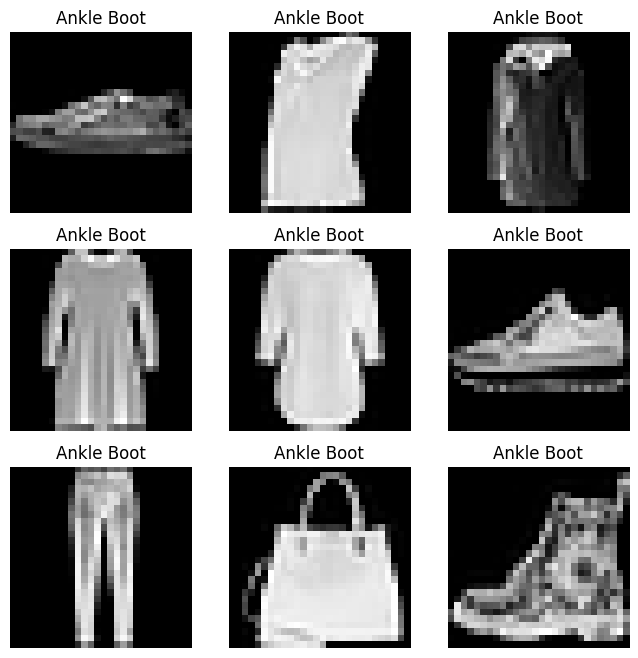

In [10]:
figure = plt.figure(figsize=(8,8))
cols,rows = 3,3
for i in range(1,cols*rows+1):
  sample_idx = torch.randint(len(training_data),size=(1,)).item()
  img,label = training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(labels_map[Label])
  plt.axis("off")
  plt.imshow(img.squeeze(),cmap="gray")
plt.show()

## Step 2: Building Dataloader

In [11]:
train_dataloader = DataLoader(training_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=64,shuffle=True)

In [12]:
train_features,train_labels = next(iter(train_dataloader))
print(f"Training batch shape: {train_features.shape}")
print(f"Labels batch shape:{train_labels.size()}")

Training batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape:torch.Size([64])


## Step 3: Build Model Architecture

In [22]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork,self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10),

    )

  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [23]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [24]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Step 4: Prepare Training and Optimaization Loop

In [26]:
# Setting Parameters
learning_rate = 1e-3
batch_size = 64
val_interval = 1
epochs = 25


In [27]:
#Initialize loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),learning_rate)

In [29]:
# Define Training step Function using Pytorch-ignite
def train_step(engine,batch):
  model.train()
  optimizer.zero_grad()
  x,y = batch
  x = x.to(device)
  y = y.to(device)
  y_pred = model(x)
  loss = loss_fn(y_pred,y)
  loss.backward()
  optimizer.step()
  return loss.item()

def eval_step(engine,batch):
  model.eval()
  with torch.no_grad():
    x,y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    return y_pred,y

In [30]:
## Define Ignite Engine
trainer = Engine(train_step)

# Evaluators for training and validation
train_evaluator = Engine(eval_step)
val_evaluator = Engine(eval_step)

In [31]:
# Metrics
Loss(loss_fn).attach(train_evaluator,"loss")
Accuracy().attach(train_evaluator,"accuracy")
Loss(loss_fn).attach(val_evaluator,"loss")
Accuracy().attach(val_evaluator,"accuracy")


In [32]:
from ignite.handlers import ModelCheckpoint

In [33]:
# Check model checkpoints
checkpoint_handler = ModelCheckpoint(
    'models','mnist',n_saved = 3,require_empty=False)

trainer.add_event_handler(
    Events.EPOCH_COMPLETED,checkpoint_handler,{'model' : model}
)

In [34]:
# Logging training loss and validation loss
train_loss_values = []
val_loss_values = []
val_accuracy_values = []


### The ProgressBar in PyTorch Ignite is a visual tool to monitor the progress of the training and evaluation processes.

In [36]:
from ignite.contrib.handlers import ProgressBar
ProgressBar().attach(trainer, output_transform=lambda x: {"batch loss" : x})
ProgressBar().attach(train_evaluator)
ProgressBar().attach(val_evaluator)


In [37]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
  train_evaluator.run(train_dataloader)
  metrics = train_evaluator.state.metrics
  train_loss = metrics["loss"]
  train_accuracy= metrics["accuracy"]
  print(f"Training - Epoch:{engine.state.epoch} Avg loss:{train_loss:.2f} Avg accuracy:{train_accuracy:.2f}")
  train_loss_values.append(train_loss)


In [38]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    val_evaluator.run(test_dataloader)
    metrics = val_evaluator.state.metrics
    val_loss = metrics['loss']
    val_accuracy = metrics['accuracy']
    print(f"Validation - Epoch: {engine.state.epoch}  Avg loss: {val_loss:.2f} Avg accuracy: {val_accuracy:.2f}")
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

In [39]:
# Training the Model
trainer.run(train_dataloader, max_epochs = epochs)

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:1 Avg loss:2.17 Avg accuracy:0.50


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 1  Avg loss: 2.17 Avg accuracy: 0.49


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:2 Avg loss:1.92 Avg accuracy:0.51


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 2  Avg loss: 1.92 Avg accuracy: 0.49


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:3 Avg loss:1.56 Avg accuracy:0.57


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 3  Avg loss: 1.56 Avg accuracy: 0.57


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:4 Avg loss:1.28 Avg accuracy:0.62


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 4  Avg loss: 1.29 Avg accuracy: 0.61


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:5 Avg loss:1.11 Avg accuracy:0.65


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 5  Avg loss: 1.11 Avg accuracy: 0.64


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:6 Avg loss:0.99 Avg accuracy:0.67


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 6  Avg loss: 1.00 Avg accuracy: 0.66


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:7 Avg loss:0.91 Avg accuracy:0.67


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 7  Avg loss: 0.93 Avg accuracy: 0.66


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:8 Avg loss:0.86 Avg accuracy:0.69


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 8  Avg loss: 0.87 Avg accuracy: 0.68


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:9 Avg loss:0.81 Avg accuracy:0.70


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 9  Avg loss: 0.83 Avg accuracy: 0.68


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:10 Avg loss:0.78 Avg accuracy:0.72


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 10  Avg loss: 0.80 Avg accuracy: 0.70


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:11 Avg loss:0.75 Avg accuracy:0.73


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 11  Avg loss: 0.77 Avg accuracy: 0.72


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:12 Avg loss:0.73 Avg accuracy:0.74


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 12  Avg loss: 0.75 Avg accuracy: 0.73


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:13 Avg loss:0.71 Avg accuracy:0.75


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 13  Avg loss: 0.73 Avg accuracy: 0.74


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:14 Avg loss:0.69 Avg accuracy:0.76


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 14  Avg loss: 0.71 Avg accuracy: 0.75


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:15 Avg loss:0.67 Avg accuracy:0.76


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 15  Avg loss: 0.69 Avg accuracy: 0.75


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:16 Avg loss:0.66 Avg accuracy:0.77


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 16  Avg loss: 0.68 Avg accuracy: 0.76


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:17 Avg loss:0.64 Avg accuracy:0.78


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 17  Avg loss: 0.66 Avg accuracy: 0.77


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:18 Avg loss:0.63 Avg accuracy:0.79


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 18  Avg loss: 0.65 Avg accuracy: 0.78


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:19 Avg loss:0.62 Avg accuracy:0.79


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 19  Avg loss: 0.64 Avg accuracy: 0.78


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:20 Avg loss:0.60 Avg accuracy:0.79


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 20  Avg loss: 0.62 Avg accuracy: 0.78


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:21 Avg loss:0.59 Avg accuracy:0.80


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 21  Avg loss: 0.61 Avg accuracy: 0.79


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:22 Avg loss:0.58 Avg accuracy:0.80


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 22  Avg loss: 0.60 Avg accuracy: 0.79


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:23 Avg loss:0.57 Avg accuracy:0.81


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 23  Avg loss: 0.60 Avg accuracy: 0.80


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:24 Avg loss:0.56 Avg accuracy:0.81


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 24  Avg loss: 0.59 Avg accuracy: 0.80


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]

Training - Epoch:25 Avg loss:0.56 Avg accuracy:0.81


[1/157]   1%|           [00:00<?]

[1/157]   1%|           [00:00<?]

Validation - Epoch: 25  Avg loss: 0.58 Avg accuracy: 0.80


State:
	iteration: 23450
	epoch: 25
	epoch_length: 938
	max_epochs: 25
	output: 0.6072072982788086
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

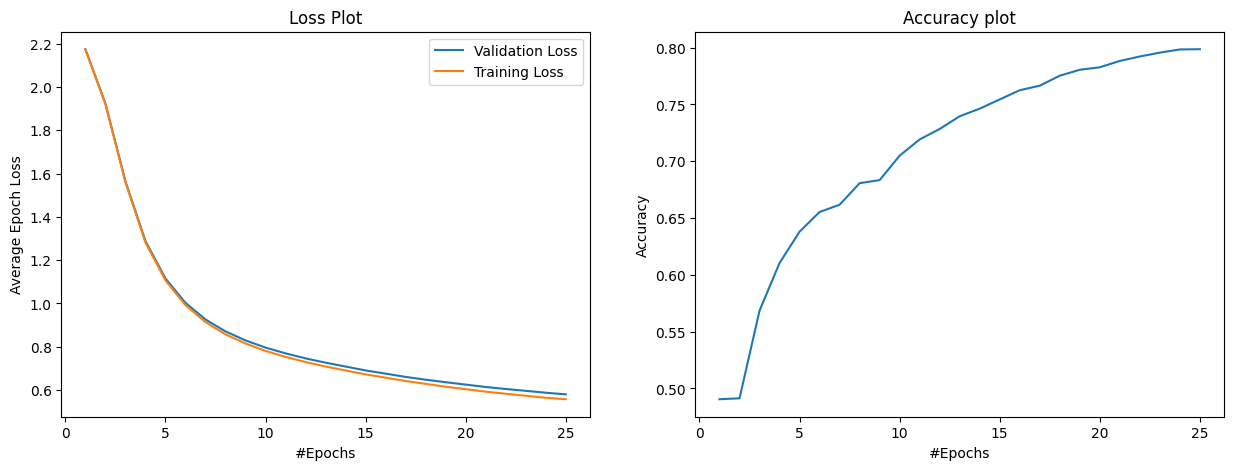

In [48]:
val_interval = 1
plt.figure(figsize=(15, 5))

# Subplot for training and validation loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(train_loss_values))]
val_num_epoch = [val_interval * (i + 1) for i in range(len(val_loss_values))]
plt.plot(val_num_epoch, val_loss_values)
plt.plot(train_num_epoch, train_loss_values)
plt.legend(["Validation Loss", "Training Loss"])
plt.xlabel("#Epochs")
plt.ylabel("Average Epoch Loss")

# Subplot for validation accuracy
plt.subplot(1, 2, 2)
val_num_epoch = [val_interval * (i + 1) for i in range(len(val_accuracy_values))]
plt.plot(val_num_epoch, val_accuracy_values)
plt.title("Accuracy plot")
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.show()

## Step 6 : Model Saving

### Saving the entire Model
* When we save the model with this approach, we could easily load the model without nedding its architecture
* But we could not resume training

In [40]:
torch.save(model,"model.pth")


In [41]:
## Loading the model


In [42]:
model = torch.load("model.pth")


## Saving the model state and relevant information
* When we save the model with this approach,we need to load the model architrcture first and only we  could load the weights.
* We could resume training from the saved checkpoints

In [49]:

checkpoint = {
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_loss": train_loss_values,
    "val_loss": val_loss_values,
    "val_accuracy": val_accuracy_values
}
torch.save(checkpoint, 'checkpoint.pth.tar')

## Loading checkpoints

In [50]:
# Loading the checkpoint
checkpoint = torch.load("checkpoint.pth.tar")

# First load the model architecture i.e. instantiate the model class and optimizer
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Then load the model weights and optimizer state
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])

# We can use these values for plotting
train_loss_values = checkpoint['train_loss']
val_loss_values = checkpoint['val_loss']
val_accuracy_values = checkpoint['val_accuracy']

## Step7 :  Model Inferencing

In [51]:
image,label = test_data[0]
print("Image shape:", image.shape)
# Adding batch dimension
image_reshaped = image.unsqueeze(0).to(device)
model = model.to(device)
print("Image shape afetr unsqueeze: ", image_reshaped.shape)
prediction = model(image_reshaped)
prediction_index = prediction.argmax().item()
print(f'Predicted: {prediction_index}')
print(f'Target: {label}')

Image shape: torch.Size([1, 28, 28])
Image shape afetr unsqueeze:  torch.Size([1, 1, 28, 28])
Predicted: 9
Target: 9


## Visualizing the images prediction


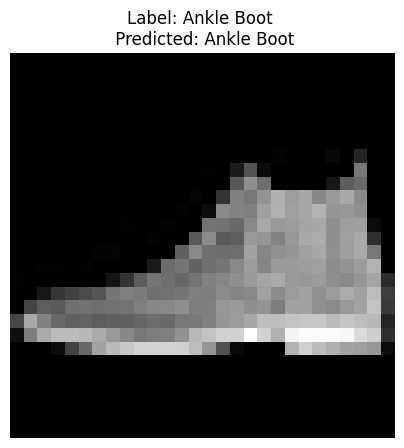

In [52]:
figure = plt.figure(figsize=(5, 5))
plt.title(f"Label: {labels_map[label]} \n Predicted: {labels_map[prediction_index]}")
plt.imshow(image.squeeze(), cmap="gray")
plt.xlabel(labels_map[prediction_index])
plt.axis("off")
plt.show()